In [1]:
# !pip install ultralytics opencv-python torch torchvision

import cv2
import torch
import numpy as np
from ultralytics import YOLO
from IPython.display import display, clear_output
import torch.nn as nn
import torchvision.models as models


In [2]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

csrnet = CSRNet().to(device)
ckpt = torch.load("finetuned_epoch_29.pth", map_location=device)
csrnet.load_state_dict(ckpt["model"])
csrnet.eval()


d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
yolo = YOLO("yolov8n.pt")   # your fine-tuned human detector

In [5]:
def preprocess(img):
    img = cv2.resize(img, (1024, 768))
    img = img / 255.0
    img = img.transpose(2,0,1)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
    return img


In [6]:
def hybrid_count(frame):
    results = yolo(frame)[0]

    clean_frame = frame.copy()

    yolo_count = 0                       # REAL person count (from YOLO)
    density_sum = 0                      # Total density from CSRNet

    DENSITY_SCALE = 0.25                 # adjust this if needed

    # ---------- YOLO PERSON DETECTION ----------
    for box in results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        if cls == 0 and conf > 0.5:      # PERSON ONLY
            yolo_count += 1

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            person_crop = frame[y1:y2, x1:x2]

            if person_crop.size == 0:
                continue

            # ---------- CSRNET (Density Model) ----------
            inp = preprocess(person_crop)
            density_map = csrnet(inp).detach().cpu().numpy()[0, 0]
            density = density_map.sum() * DENSITY_SCALE

            density_sum += density

            # Draw bounding box + YOLO label
            cv2.rectangle(clean_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(clean_frame, f"YOLO:1 | D:{density:.1f}", 
                        (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # ---------- FUSION LOGIC ----------
    if yolo_count <= 5:
        # For small crowds, YOLO is more accurate
        final_count = yolo_count

    else:
        # For bigger crowds, fuse YOLO + Density
        final_count = int(0.7 * yolo_count + 0.3 * density_sum)

        # If YOLO misses too many (common in dense crowd)
        if yolo_count < 3 and density_sum > final_count:
            final_count = int(density_sum)

    # ---------- CROWD ALERT ----------
    alert = "SAFE"
    color = (0, 255, 0)

    if final_count > 3:    # Adjust threshold as needed
        alert = "⚠️ CROWD ALERT"
        color = (0, 0, 255)

    # ---------- DRAW COUNTERS ----------
    cv2.putText(clean_frame, f"YOLO: {yolo_count} | Density: {density_sum:.1f}", 
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

    cv2.putText(clean_frame, f"Final Count: {final_count} | {alert}",
                (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

    return clean_frame, final_count, alert


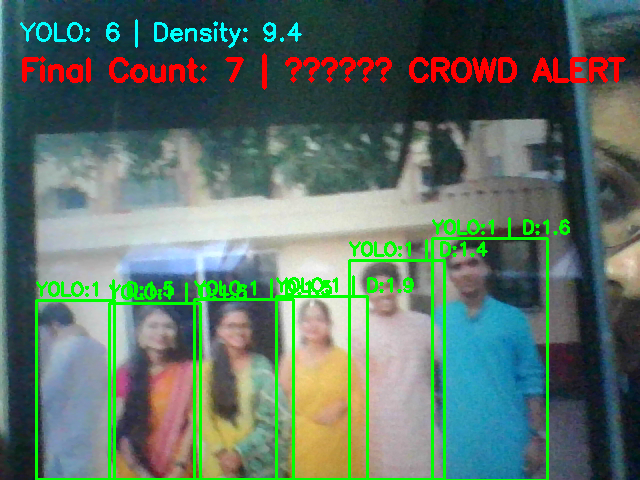

Count: 7.00 | Alert: ⚠️ CROWD ALERT

0: 480x640 5 persons, 127.0ms
Speed: 38.7ms preprocess, 127.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


KeyboardInterrupt: 

In [7]:
from PIL import Image
from IPython.display import display, clear_output
import cv2
import time

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Camera not found!")
        break

    output, count, alert = hybrid_count(frame)   # your function

    # Convert BGR → RGB for Jupyter Notebook
    rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    # Display frame inside Jupyter
    clear_output(wait=True)
    display(Image.fromarray(rgb))

    print(f"Count: {count:.2f} | Alert: {alert}")

    # Slow down refresh so notebook doesn't freeze
    time.sleep(0.05)


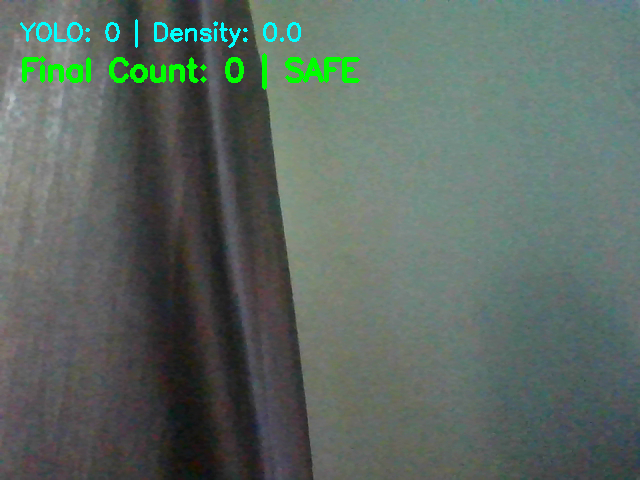

Count: 0.00 | Alert: SAFE



In [ ]:
from PIL import Image
from IPython.display import display, clear_output
import cv2
import time

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Camera not found!")
        break

    output, count, alert = hybrid_count(frame)   # your function

    # Convert BGR → RGB for Jupyter Notebook
    rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    # Display frame inside Jupyter
    clear_output(wait=True)
    display(Image.fromarray(rgb))

    print(f"Count: {count:.2f} | Alert: {alert}")

    # Slow down refresh so notebook doesn't freeze
    time.sleep(0.05)
